In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
from pathlib import Path
from scipy.optimize import least_squares
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
%matplotlib inline

## LOADING IMAGES THROUGH MY GDRIVE

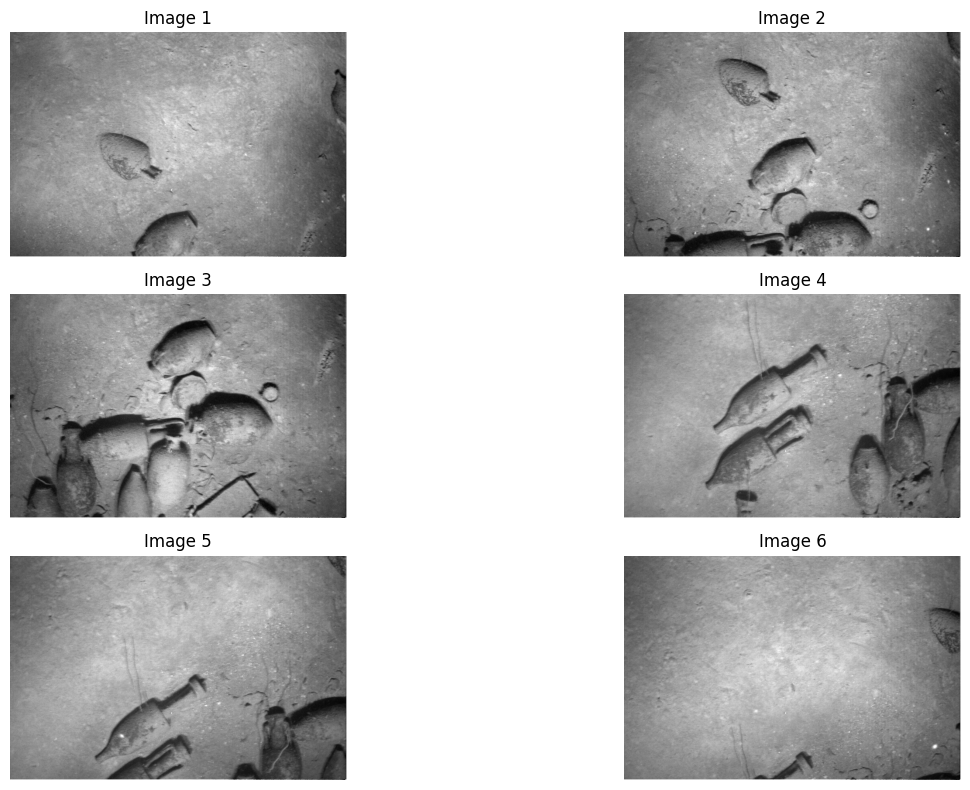

In [3]:
image_dir = "/content/drive/MyDrive/HW2_Images/6Images/6Images"
image_paths = sorted(glob.glob(image_dir + "/*.tif"))

imgs = [cv2.imread(p) for p in image_paths]

plt.figure(figsize=(15, 8))
for i, img in enumerate(imgs, 1):
    plt.subplot(3, 2, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## HELPER FUNCTIONS

In [4]:
''' normalize_image() -> Converts the Image to grayscale and applies CLAHE for contrast enhancement '''

def normalize_image(img):

    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    return gray

''' compute_features() -> Extracts SIFT keypoints and descriptors from the normalized image '''

def compute_features(img):

    sift = cv2.SIFT_create()
    gray = normalize_image(img)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors, gray

''' match_features() -> Matches descriptors using BFMatcher with Lowe’s ratio test for robustness '''

def match_features(desc1, desc2, ratio=0.8):

    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = [m for m, n in matches if m.distance < ratio * n.distance]
    return good

''' compute_homography() -> Computes homography between 2 sets of keypoints, and uses RANSAC for robustness (reject outliers) '''

def compute_homography(kp1, kp2, matches, ransac_thresh=3.0):

    if len(matches) < 4:
        return None, None, None, None
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
    return H, pts1, pts2, mask

''' refine_homography() -> Optimizes the homography matrix by minimizing reprojection error with Levenberg–Marquardt '''

def refine_homography(H, pts1, pts2, mask):

    if H is None or mask is None:
        return H
    inliers1 = pts1[mask.ravel() == 1]
    inliers2 = pts2[mask.ravel() == 1]

    if len(inliers1) < 8:
        return H

    def rep_error(h):
        H_mat = h.reshape(3, 3)
        pts1_h = np.hstack([inliers1, np.ones((len(inliers1), 1))])
        proj = (H_mat @ pts1_h.T).T
        proj = proj[:, :2] / proj[:, 2:3]
        return (proj - inliers2).ravel()

    res = least_squares(rep_error, H.ravel(), method='lm')
    H_refined = res.x.reshape(3, 3)
    return H_refined / H_refined[2, 2]

''' visualize_matches() -> Displays feature macthes between two Images '''

def visualize_matches(img1, img2, kp1, kp2, matches, mask=None, title="", max_draw=100):

    if mask is not None:
        matches = [m for m, keep in zip(matches, mask.ravel()) if keep]
    matches_to_draw = matches[:max_draw]
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches_to_draw, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14, 7))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{title} ({len(matches_to_draw)} matches shown)")
    plt.axis("off")
    plt.show()


In [5]:
''' draw_matches -> Extracts SIFT features for all images, computes and refines homographies between every pair, stores match statistics, and visualizes selected pairs '''

def draw_matches(imgs, visualize_pairs=None):

    features = []
    for img in imgs:
        kp, desc, gray = compute_features(img)
        features.append({'kp': kp, 'desc': desc})

    homographies = {} # This will store all the possible homographies
    match_stats = {} # This will store the points(1&2) and inliers count

    for i in range(len(imgs)):
        for j in range(len(imgs)):
            if i == j:
                continue

            kp1, desc1 = features[i]['kp'], features[i]['desc']
            kp2, desc2 = features[j]['kp'], features[j]['desc']

            matches = match_features(desc1, desc2)
            if len(matches) < 4:
                continue

            H, pts1, pts2, mask = compute_homography(kp1, kp2, matches)
            if H is None:
                continue

            H_ref = refine_homography(H, pts1, pts2, mask)
            homographies[(i+1, j+1)] = H_ref

            inliers = np.sum(mask) if mask is not None else 0
            match_stats[(i+1, j+1)] = {
                "inliers": inliers,
                "pts1": pts1[mask.ravel()==1] if mask is not None else pts1,
                "pts2": pts2[mask.ravel()==1] if mask is not None else pts2
            }

            # Only visualize chosen pairs
            if visualize_pairs and (i, j) in visualize_pairs:
                print(f"Visualizing match between Image {i+1} and {j+1}")
                visualize_matches(imgs[i], imgs[j], kp1, kp2, matches, mask,
                                  title=f"Image {i+1} vs Image {j+1}")

    return homographies, match_stats

Visualizing match between Image 1 and 2


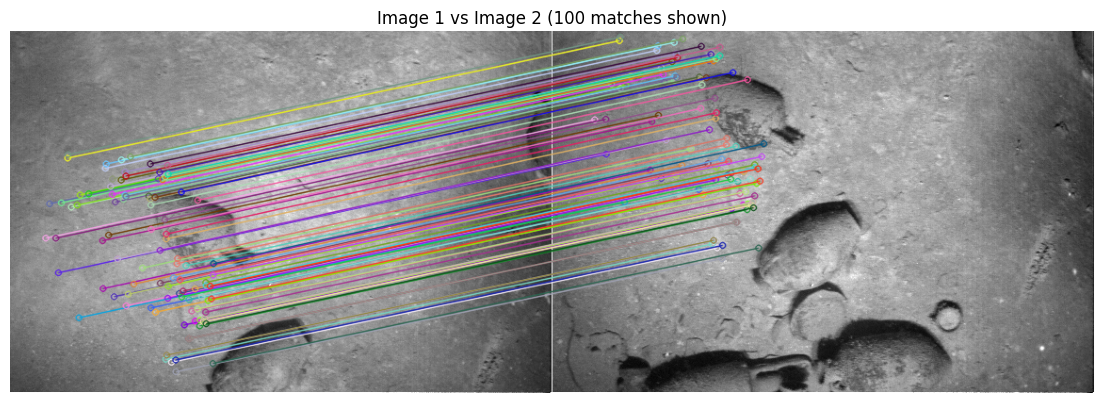

Visualizing match between Image 2 and 3


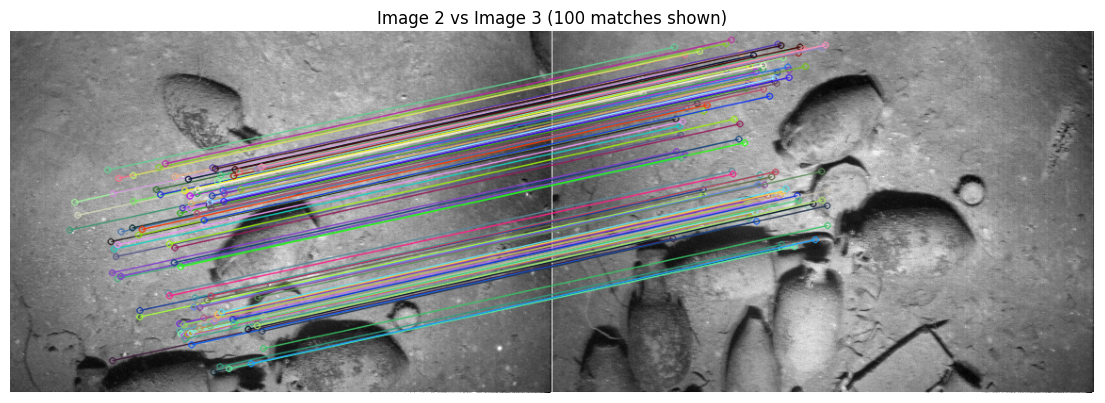

Visualizing match between Image 3 and 4


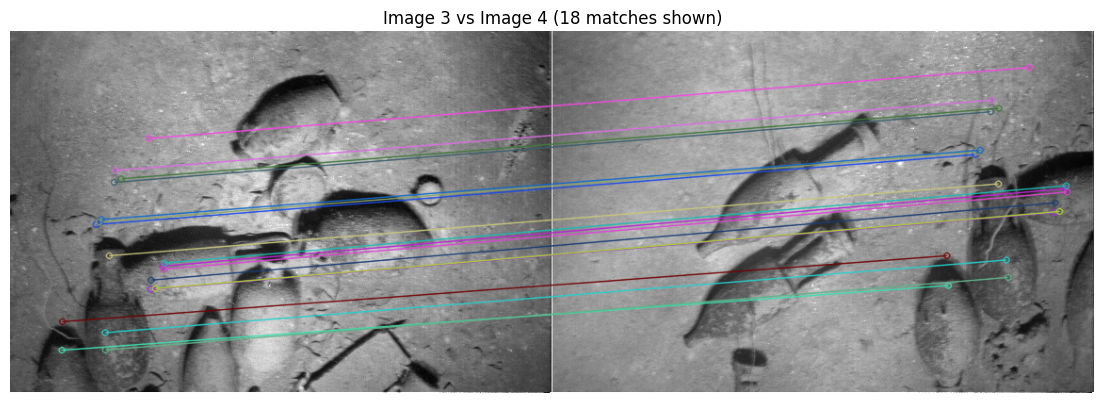

Visualizing match between Image 4 and 5


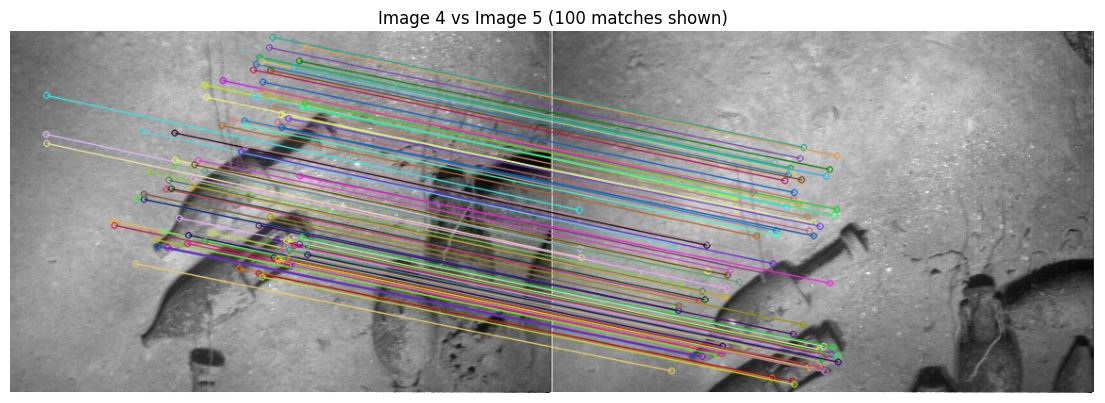

Visualizing match between Image 5 and 6


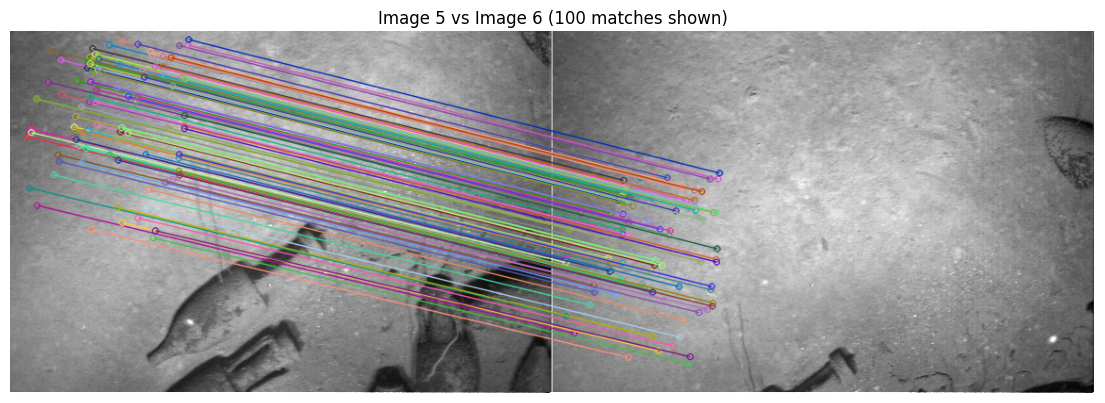

In [6]:
sequential_pairs = [(i, i+1) for i in range(len(imgs)-1)]

_, _ = draw_matches(imgs, visualize_pairs=sequential_pairs)

Visualizing match between Image 1 and 5


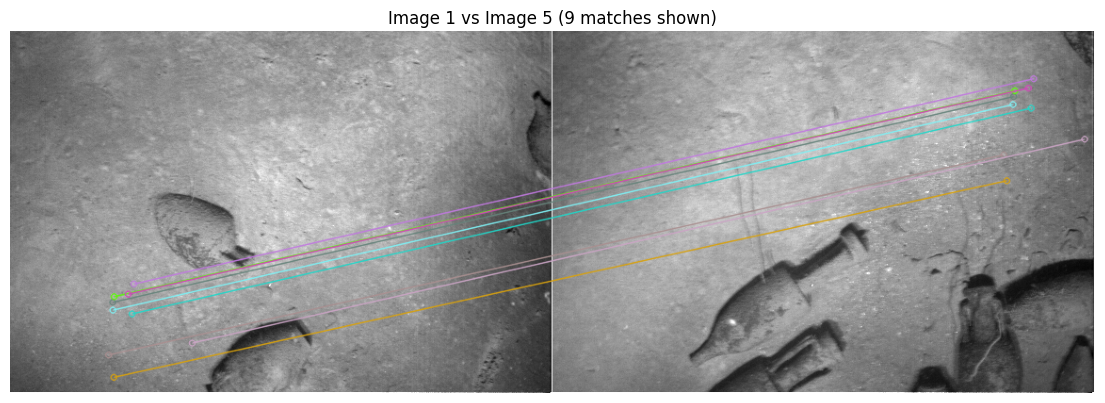

Visualizing match between Image 1 and 6


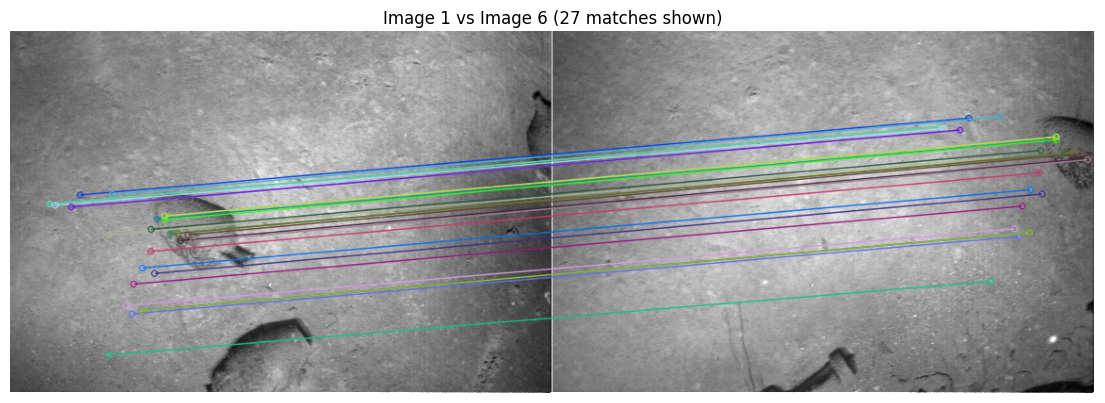

Visualizing match between Image 2 and 4


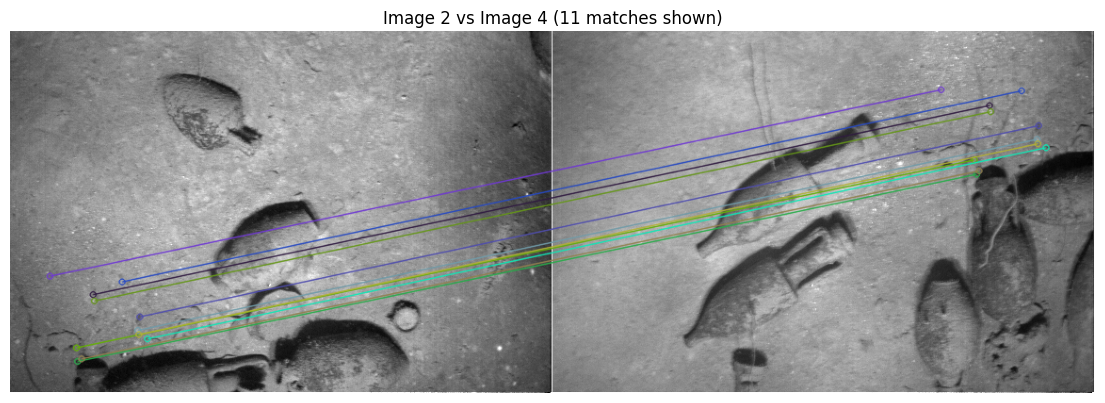

Visualizing match between Image 2 and 5


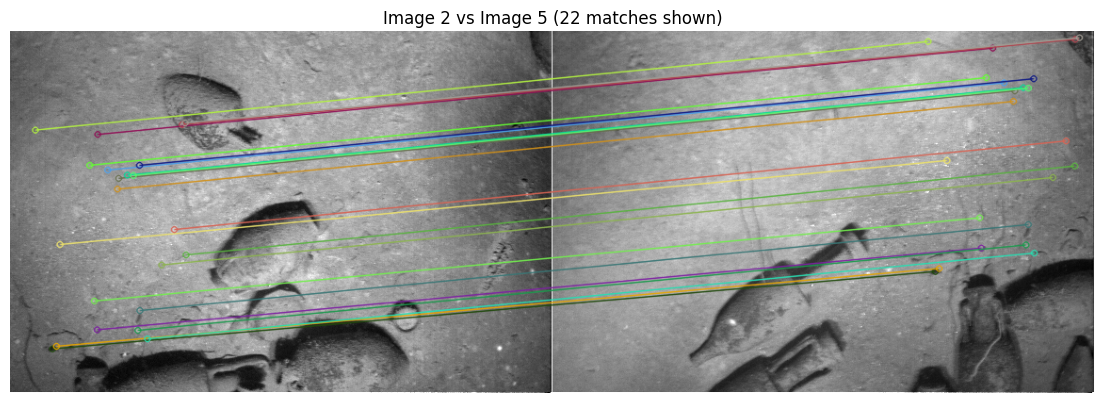

Visualizing match between Image 2 and 6


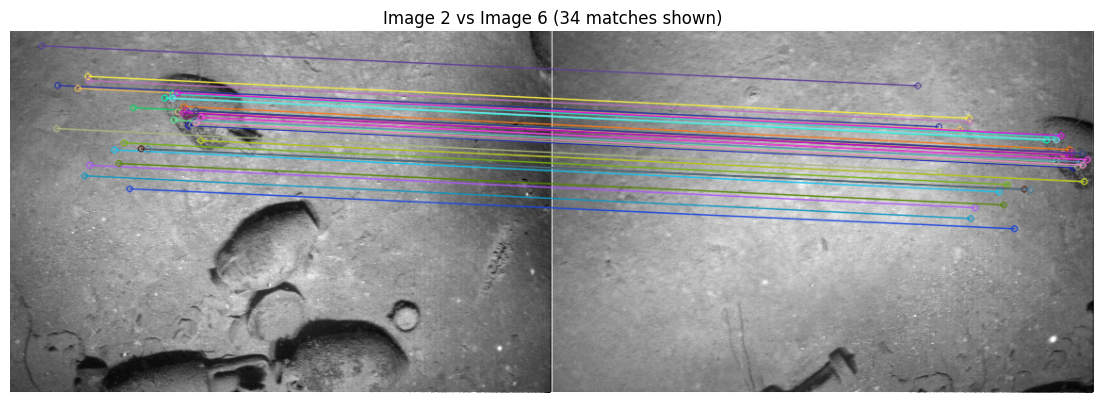

Visualizing match between Image 3 and 5


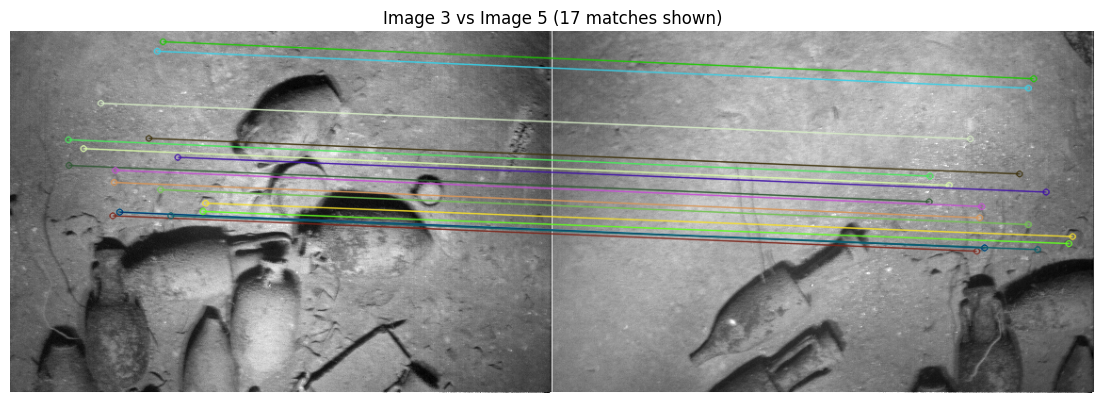

In [7]:
non_sequential_pairs = [(0, 5), (1, 4), (1, 3), (2, 4), (0, 4), (1, 5)]

_, _ = draw_matches(imgs, visualize_pairs=non_sequential_pairs)

In [8]:
H, match_stats = draw_matches(imgs, visualize_pairs=None)

In [11]:
H_Mosaic_List = []
for (i, j) in sequential_pairs:
    H_Mosaic_List.append(H[(i + 1, j + 1)])

H_Mosaic_List.append(H[(6, 1)])

print(f"Mosaic homographies:\n{H_Mosaic_List}")

Mosaic homographies:
[array([[ 9.74482947e-01, -5.38131448e-02,  1.80448959e+01],
       [ 1.56766496e-02,  9.62793205e-01, -1.23398155e+02],
       [ 1.37307580e-05, -1.55441487e-04,  1.00000000e+00]]), array([[ 9.96256723e-01, -3.75677574e-02,  2.89957295e+01],
       [ 5.19541837e-03,  9.64028055e-01, -1.25743690e+02],
       [ 4.77463561e-05, -1.23944153e-04,  1.00000000e+00]]), array([[ 1.87230208e+00,  2.26722334e-01,  2.75098842e+02],
       [ 3.36615413e-02,  1.10743828e+00, -8.62632290e+01],
       [ 8.97659225e-04,  8.20644873e-05,  1.00000000e+00]]), array([[ 9.91503860e-01,  3.26988315e-02, -1.14641591e+01],
       [-2.35107925e-02,  1.02641146e+00,  1.21121827e+02],
       [-2.34246604e-05,  1.01940207e-04,  1.00000000e+00]]), array([[ 1.01214479e+00,  5.43258308e-02, -1.45710735e+01],
       [-1.07893115e-03,  1.03796800e+00,  1.41489228e+02],
       [ 1.17620337e-05,  2.01677015e-04,  1.00000000e+00]]), array([[ 8.17765286e-01, -9.00481916e-03, -2.98405869e+02],
       [

In [12]:
''' photomosaicing() -> Chains sequential homographies to the chosen reference image and warps/blends all images into a single mosaic '''

def photomosaicing(images, H_Mosaic_List, reference_idx=2):

    num_images = len(images)

    H_to_ref = {}
    H_to_ref[reference_idx] = np.eye(3)

    # Images that are before the reference
    for i in range(reference_idx - 1, -1, -1):
        H_chain = np.eye(3)
        for j in range(i, reference_idx):
            H_chain = H_Mosaic_List[j] @ H_chain
        H_to_ref[i] = H_chain

    # Images that are after the reference
    for i in range(reference_idx + 1, num_images):
        H_chain = np.eye(3)
        for j in range(i - 1, reference_idx - 1, -1):
            H_chain = np.linalg.inv(H_Mosaic_List[j]) @ H_chain
        H_to_ref[i] = H_chain

    # Canvas size
    h, w = images[0].shape[:2]
    all_corners = []

    for i in range(num_images):
        corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

        if i in H_to_ref:
            corners_ref = cv2.perspectiveTransform(corners.reshape(1, -1, 2), H_to_ref[i])
            all_corners.append(corners_ref)
        else:
            all_corners.append(corners.reshape(1, -1, 2))

    all_corners = np.vstack(all_corners)

    x_min, y_min = all_corners[:, :, 0].min(), all_corners[:, :, 1].min()
    x_max, y_max = all_corners[:, :, 0].max(), all_corners[:, :, 1].max()

    padding = 10  # Padding to fit the mosaic in the canvas properly
    canvas_width = int(x_max - x_min) + 2 * padding
    canvas_height = int(y_max - y_min) + 2 * padding

    tx = -x_min + padding
    ty = -y_min + padding

    T = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])

    if len(images[0].shape) == 3:
        mosaic = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    else:
        mosaic = np.zeros((canvas_height, canvas_width), dtype=np.uint8)

    blend_weights = np.zeros((canvas_height, canvas_width), dtype=np.float32)

    for i in range(num_images):
        print(f"Warping Image {i+1}...")

        if i in H_to_ref:
            H_final = T @ H_to_ref[i]

            # Warp image
            warped = cv2.warpPerspective(images[i], H_final, (canvas_width, canvas_height))

            # Creating mask for the warped image
            if len(warped.shape) == 3:
                mask = (warped > 0).any(axis=2)
            else:
                mask = (warped > 0)

            # Updating blend weights
            new_weights = mask.astype(np.float32)
            total_weights = blend_weights + new_weights

            if len(images[0].shape) == 3:
                for c in range(3):
                    mosaic_c = mosaic[:, :, c].astype(np.float32)
                    warped_c = warped[:, :, c].astype(np.float32)

                    mosaic_c[mask] = (mosaic_c[mask] * blend_weights[mask] + warped_c[mask] * new_weights[mask]) / np.maximum(total_weights[mask], 1)
                    mosaic[:, :, c] = np.clip(mosaic_c, 0, 255).astype(np.uint8)
            else:
                mosaic_f = mosaic.astype(np.float32)
                warped_f = warped.astype(np.float32)
                mosaic_f[mask] = (mosaic_f[mask] * blend_weights[mask] +
                                 warped_f[mask] * new_weights[mask]) / np.maximum(total_weights[mask], 1)
                mosaic = np.clip(mosaic_f, 0, 255).astype(np.uint8)

            blend_weights = np.maximum(blend_weights, new_weights)

    return mosaic

Warping Image 1...
Warping Image 2...
Warping Image 3...
Warping Image 4...
Warping Image 5...
Warping Image 6...


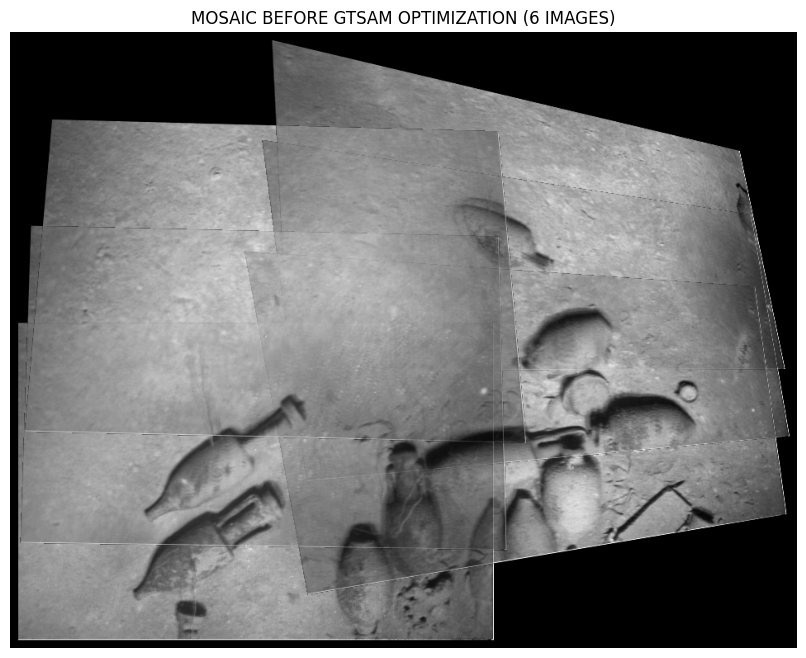

In [ ]:
mosaic = photomosaicing(imgs, H_Mosaic_List, reference_idx=3)

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.title("MOSAIC BEFORE GTSAM OPTIMIZATION (6 IMAGES)")
plt.axis('off')
plt.show()

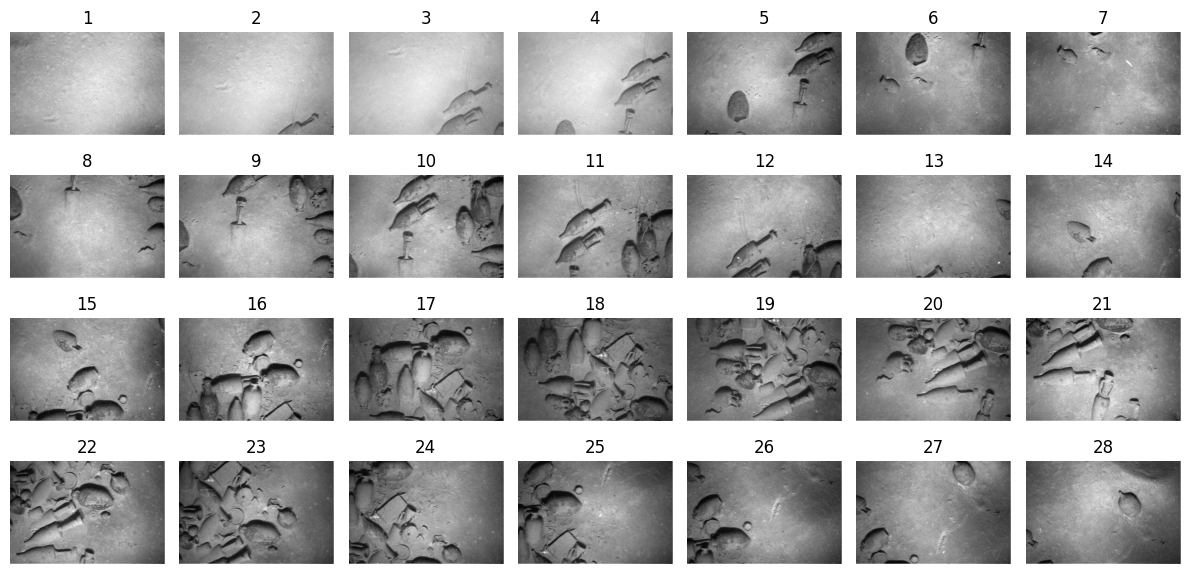

In [96]:
image_dir_1 = "/content/drive/MyDrive/HW2_Images/29images/29images/first_column"
image_dir_2 = "/content/drive/MyDrive/HW2_Images/29images/29images/second_column"
image_dir_3 = "/content/drive/MyDrive/HW2_Images/29images/29images/third_column"
image_dir_4 = "/content/drive/MyDrive/HW2_Images/29images/29images/fourth_column"

images_1 = sorted(glob.glob(image_dir_1 + "/*.tif"))
images_2 = sorted(glob.glob(image_dir_2 + "/*.tif"))
images_3 = sorted(glob.glob(image_dir_3 + "/*.tif"))
images_4 = sorted(glob.glob(image_dir_4 + "/*.tif"))

image_paths = images_1 + images_2 + images_3 + images_4

imgs_28 = [cv2.imread(p) for p in image_paths]

plt.figure(figsize=(12, 6))
for i, img in enumerate(imgs_28):
    plt.subplot(4, 7, i+1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(str(i+1))
plt.tight_layout()
plt.show()

In [97]:
H_28, match_stats_28 = draw_matches(imgs_28, visualize_pairs=None)

In [98]:
sequential_pairs_28 = [(i, i+1) for i in range(len(imgs_28)-1)]
H_Mosaic_List_28 = []
for (i, j) in sequential_pairs_28:
    H_Mosaic_List_28.append(H_28[(i+1, j+1)])

Warping Image 1...
Warping Image 2...
Warping Image 3...
Warping Image 4...
Warping Image 5...
Warping Image 6...
Warping Image 7...
Warping Image 8...
Warping Image 9...
Warping Image 10...
Warping Image 11...
Warping Image 12...
Warping Image 13...
Warping Image 14...
Warping Image 15...
Warping Image 16...
Warping Image 17...
Warping Image 18...
Warping Image 19...
Warping Image 20...
Warping Image 21...
Warping Image 22...
Warping Image 23...
Warping Image 24...
Warping Image 25...
Warping Image 26...
Warping Image 27...
Warping Image 28...


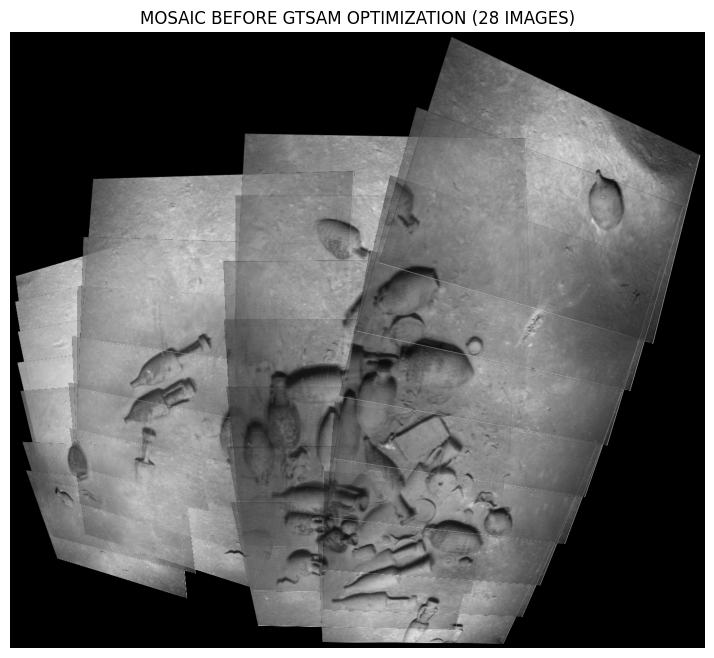

In [100]:
mosaic_28 = photomosaicing(imgs_28, H_Mosaic_List_28, reference_idx=14)

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(mosaic_28, cv2.COLOR_BGR2RGB))
plt.title("MOSAIC BEFORE GTSAM OPTIMIZATION (28 IMAGES)")
plt.axis('off')
plt.show()